# XGB - Notes on tuning for production

### Problem Statement: Predict risk of diabetes amongst PIMA Indians

In [58]:
import numpy as np
import pandas as pd
from numpy import loadtxt

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split

# for xgboost pima example
import xgboost as xgb

# for feature selection
from sklearn.feature_selection import RFE, SelectFromModel

# sklearn utility to compare algorithms
from sklearn import model_selection

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

# pipelines
from sklearn.pipeline import Pipeline

# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
# %history

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', header = None)
# dataset = loadtxt('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', delimiter=",")

## 1. Data cleaning and formatting

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# df.shape
# df.columns
# df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
0    768 non-null int64
1    768 non-null int64
2    768 non-null int64
3    768 non-null int64
4    768 non-null int64
5    768 non-null float64
6    768 non-null float64
7    768 non-null int64
8    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.columns = ['pregnant','glucose', 'bp', 'skinfold', 'insulin', 'bmi', 'pedigree', 'age', 'diabetes']
df.tail()

,pregnant,glucose,bp,skinfold,insulin,bmi,pedigree,age,diabetes
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [6]:
df.isnull().values.any()
# df.isnull().values.sum()
# df.fillna(0)
# df.fillna(how="mean")

False

In [7]:
df.describe()
# things to explore in EDA:
# - possible outliers in: pregnancy, skinfold, insulin, bmi, 
# - why are there zero values for: glucose, bp, skinfold, insulin, bmi
# - possible class imbalance for diabetes

,pregnant,glucose,bp,skinfold,insulin,bmi,pedigree,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
df.groupby('diabetes').size()
# class imbalance - will need to address during sampling for
# cross-val and train-test splits

diabetes
0    500
1    268
dtype: int64

In [9]:
# examine missing values
l = {}
for i in df.columns:
    try: 
        l[i] = df[i].value_counts()[0]
    except Exception:
        pass
l
# skinfold (227), insulin (374), bmi (11), glucose (5), bp (35) = 0
# these values do not make sense - will need an appropriate imputer strategy
# 15, 17 times pregnant? outliers perhaps

{'pregnant': 111,
 'glucose': 5,
 'bp': 35,
 'skinfold': 227,
 'insulin': 374,
 'bmi': 11,
 'diabetes': 500}

In [10]:
# fix missing values
def replace_missing_values():
    selected_cols = ['glucose', 'bp', 'skinfold', 'insulin', 'bmi']
    for col in selected_cols:
        median = df[col].median()
        df[col] = df[col].replace(0, median)

replace_missing_values()

# obviously, can also do this in other ways

In [11]:
# examine outliers
df[df['bmi'] > 50]
df[df['pregnant'] > 10]
df[df['insulin'] > 700]
df[df['skinfold'] > 90]

# normally would check inter-quantile range

,pregnant,glucose,bp,skinfold,insulin,bmi,pedigree,age,diabetes
579,2,197,70,99,30.5,34.7,0.575,62,1


In [12]:
# fix outliers
# the only obviously odd value seems to be for skinfold = 99, drop that value
# there may be others, requires more domain understanding
df.drop(df[df['skinfold'] > 90].index, inplace=True)

In [13]:
df.skew()
# df.kurtosis()

pregnant    0.899687
glucose     0.531414
bp          0.141041
skinfold    0.722207
insulin     2.691293
bmi         0.602031
pedigree    1.920210
age         1.132505
diabetes    0.638949
dtype: float64

## 2. Exploratory data analysis

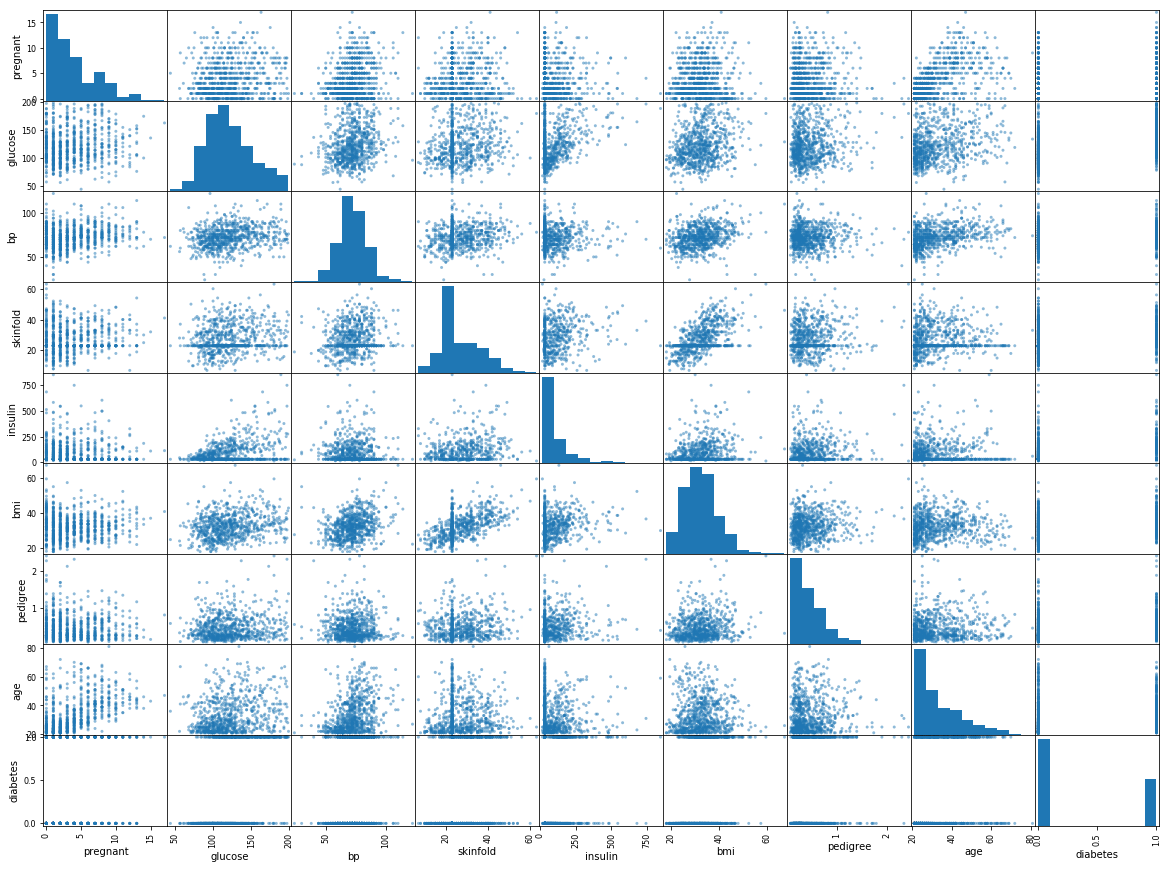

In [14]:
scatter_matrix(df, figsize = (20, 15))
plt.show()

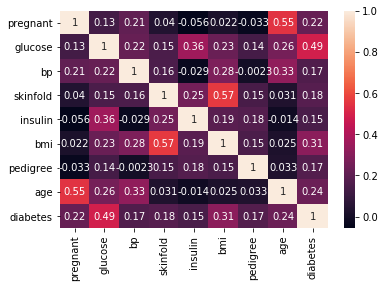

In [15]:
sns.heatmap(df.corr(), annot = True)
plt.show()

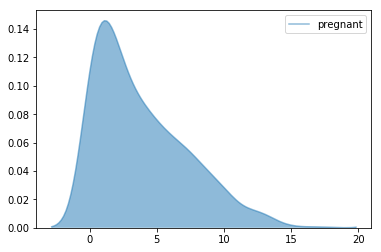

In [16]:
sns.kdeplot(df['pregnant'].dropna(), shade = True, alpha = 0.5)
plt.show()

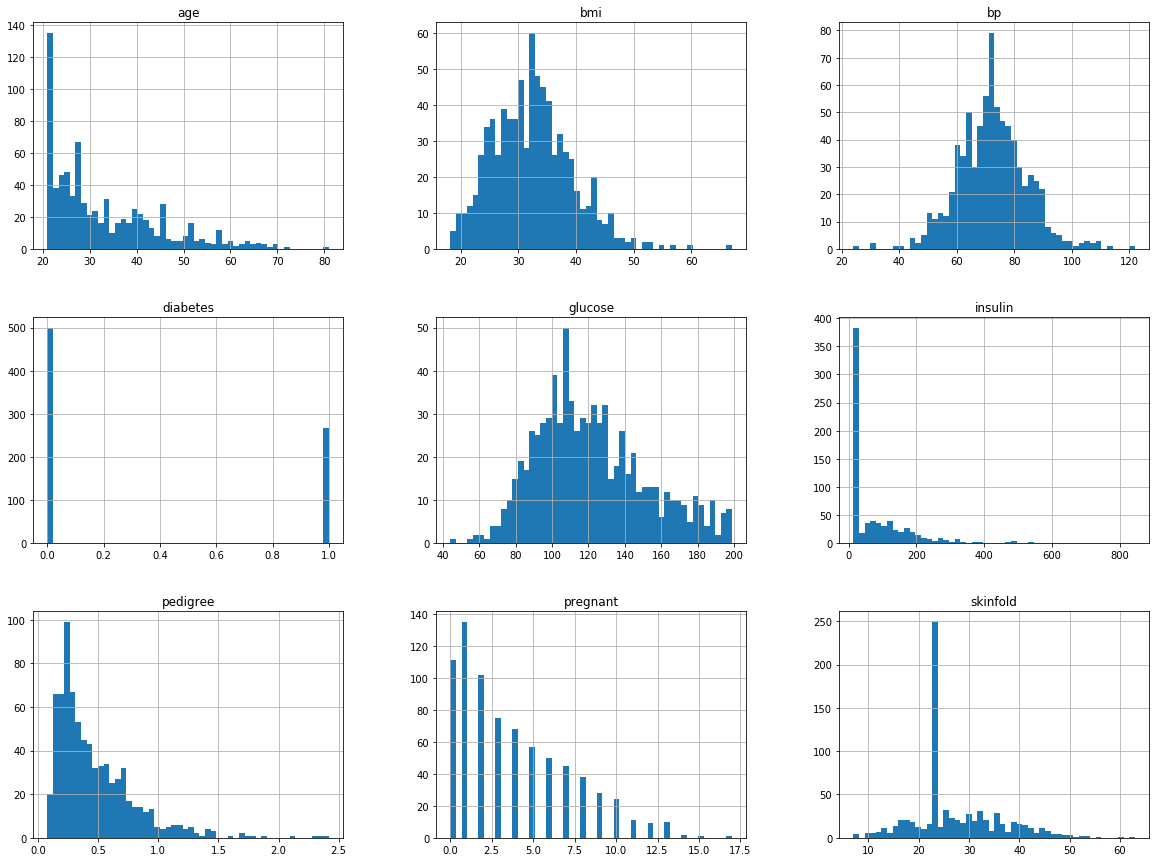

In [17]:
# df.plot(kind = 'hist', bins = 50, figsize = (10, 10))
df.hist(bins = 50, figsize = (20, 15))
plt.show()

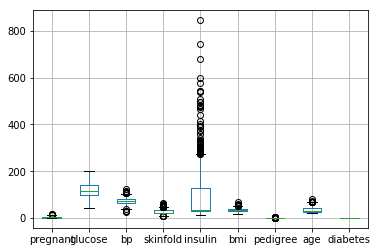

In [18]:
df.boxplot()
plt.show()

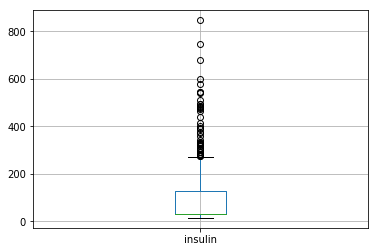

In [19]:
df.boxplot(column='insulin')
# sns.swarmplot(x = 'diabetes', y = 'insulin', data = df)
plt.show()
# requires further investigation
# what is pedigree function - data leakage?

## 3. Feature engineering and selection/extraction

In [20]:
# split data into x and y
X = df.iloc[:,0:8]
y = df.iloc[:,8]

# split data into train and test sets
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

In [21]:
# or instead of median filling function above, can use Imputer object
imputer = Imputer(strategy='median')

# train on the training features
imputer.fit(X_train)

# transform both training data and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

print('Missing values in training features: ', np.sum(np.isnan(X_train)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [22]:
# create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# fit on the training data
scaler.fit(X_train)

# transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# convert y to one-dimensional array (vector)
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [24]:
# possible feature drop: skinfold vs bmi, indicative of the same info.
df.corr()['bmi'].sort_values()

pregnant    0.021786
age         0.024799
pedigree    0.153394
insulin     0.189341
glucose     0.231285
bp          0.281243
diabetes    0.312068
skinfold    0.566424
bmi         1.000000
Name: bmi, dtype: float64

## 4. Establish a baseline and compare several machine learning models on a performance metric

For regression, typical models to evaluate (scikit-learn) - besides XGB:
1. Linear Regression - LinearRegression()
2. Support Vector Machine Regression - SVR(C = 1000, gamma = 0.1)
3. Random Forest Regression - RandomForestRegressor(random_state=60)
4. Gradient Boosting Regression - GradientBoostingRegressor(random_state=60)
5. K-Nearest Neighbors Regression - KNeighborsRegressor(n_neighbors=10)
6. Decision Tree Regressor - DecisionTreeRegressor()

For classification, typical models to evaluate (scikit-learn) - besides XGB:
1. Logistic Regression - LogisticRegression()
2. K-Nearest Neighbours Classifier - KNeighborsClassifier()
3. Gaussian Naive Bayes - GaussianNB()
4. Support Vector Machine Classifier - SVC()
5. Linear SVM Classifier - LinearSVC()
6. Random Forest Classifier - RandomForestClassifier()
7. Decision Tree Classifier - DecisionTreeClassifier()

For performance metric:
+ Regression: 
    + rmse – root mean square error
    + mae – mean absolute error
+ Classification:
    + logloss – negative log-likelihood
    + error – Binary classification error rate (0.5 threshold)
    + merror – Multiclass classification error rate
    + mlogloss – Multiclass logloss
    + auc – area under the curve

In this PIMA classification case I would:
+ compare the classifiers mentioned above + the XGB Classifier
+ use an eval metric of auc for binary classification (with imbalanced sets)
+ pick the best performing model

Here we assume XGBoost

In [25]:
# from Vish:
# fit model no training data
model = xgb.XGBClassifier(n_estimators = 100)
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [26]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.59%


## 5. Perform hyperparameter tuning on the best model to optimize it for the problem

In [ ]:
# X_train, y_train, X_test, y_test

In [27]:
# tuning hyper parameters: general
model = xgb.XGBClassifier()
random_state = 7
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# use stratified sampling for imbalanced classes
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
# grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold, verbose=1)
result = grid_search.fit(X_train, y_train)
# result.cv_results_
# GridSearchCV??

In [28]:
# summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.843678 using {'max_depth': 2, 'n_estimators': 150}
0.833243 (0.055547) with: {'max_depth': 2, 'n_estimators': 50}
0.840857 (0.050712) with: {'max_depth': 2, 'n_estimators': 100}
0.843678 (0.045639) with: {'max_depth': 2, 'n_estimators': 150}
0.842747 (0.045937) with: {'max_depth': 2, 'n_estimators': 200}
0.829331 (0.057423) with: {'max_depth': 4, 'n_estimators': 50}
0.824480 (0.052260) with: {'max_depth': 4, 'n_estimators': 100}
0.821233 (0.054880) with: {'max_depth': 4, 'n_estimators': 150}
0.813463 (0.056053) with: {'max_depth': 4, 'n_estimators': 200}
0.820954 (0.054660) with: {'max_depth': 6, 'n_estimators': 50}
0.812400 (0.054851) with: {'max_depth': 6, 'n_estimators': 100}
0.813371 (0.053378) with: {'max_depth': 6, 'n_estimators': 150}
0.811365 (0.054696) with: {'max_depth': 6, 'n_estimators': 200}
0.813167 (0.056418) with: {'max_depth': 8, 'n_estimators': 50}
0.802124 (0.062301) with: {'max_depth': 8, 'n_estimators': 100}
0.802913 (0.061566) with: {'max_depth': 8, 'n_est

In [29]:
# tuning hyper parameters: learning_rate for regularization
# grid search
model = xgb.XGBClassifier()
random_state = 7
max_depth = [2]
n_estimators = [150]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

#scoring: neg_log_loss / neg_mean_squared_error / roc_auc
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
result = grid_search.fit(X_train, y_train)
result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
# summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.843678 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}
0.760158 (0.047101) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 150}
0.794455 (0.051001) with: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 150}
0.828497 (0.061956) with: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 150}
0.843678 (0.045639) with: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}
0.833734 (0.046330) with: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 150}
0.819510 (0.049894) with: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 150}


In [31]:
# early stopping on previous model
# evaluate and report on performance on a test set during training
eval_set  = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric="auc", eval_set=eval_set, verbose = False)
# reports performance after each tree is added, set verbose = True

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### DMatrix, early stopping and xgb.cv()

In [32]:
# performance advantage of xgboost comes with using DMatrix
feature_names = X.columns
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train, feature_names=feature_names)

In [33]:
# use early stopping as a means of regularizing
# stops training when when holdout test metric stops improving
params = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
            'max_depth': 5,
                 "silent": 1}

# stratified = 'y' for our imbalanced classes
# metrics = error / auc / accuracy
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=60, stratified = 'y',
                    early_stopping_rounds=10, metrics="auc", 
                    as_pandas=True, seed=123)

In [34]:
# train with dmatrix
params = result.best_params_
params["silent"] =  1
d_model = xgb.train(dtrain = data_dmatrix, params = params, num_boost_round=60)

In [35]:
cv_results.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
6,0.933707,0.011328,0.767845,0.049047
7,0.936104,0.008063,0.761081,0.052390
8,0.942947,0.010592,0.769348,0.057756
9,0.946223,0.010994,0.774638,0.049412
10,0.951092,0.009629,0.789911,0.039616


## 6. Evaluate the best model on the testing set

In [45]:
# fit tuned model to training data
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [46]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

## 7. Interpret the model results

In [38]:
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

[[122  23]
 [ 31  55]]


In [39]:
# classification report (see f1-score)
report = classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       0.80      0.84      0.82       145
          1       0.71      0.64      0.67        86

avg / total       0.76      0.77      0.76       231



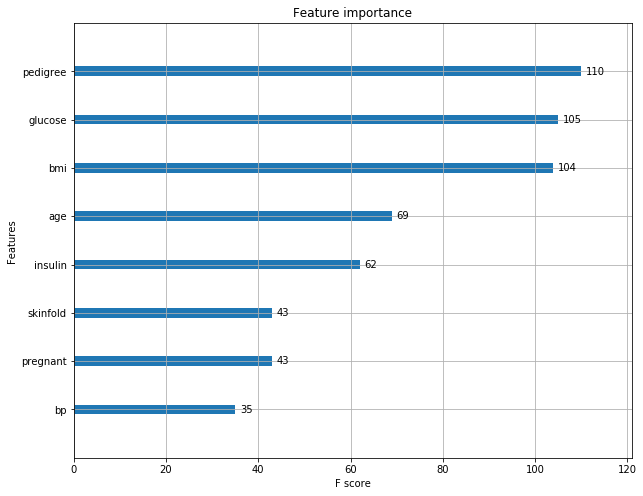

In [40]:
# feature importance
model.fit(X, y)
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 8)

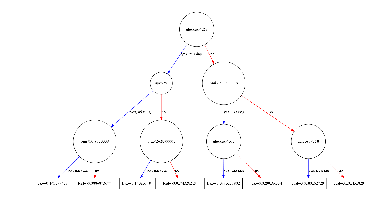

In [41]:
# plot tree
xgb.plot_tree(model, num_trees = 4)
plt.rcParams['figure.figsize'] = [300, 100]
plt.show()

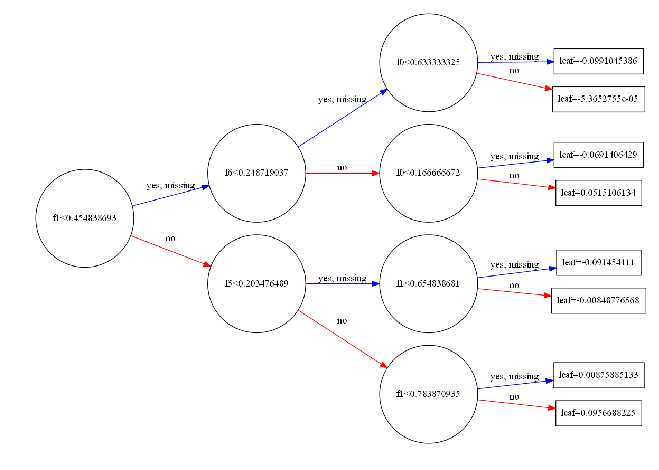

In [54]:
# plot tree sideways
xgb.plot_tree(model, num_trees = 9, rankdir = "LR")
plt.rcParams['figure.figsize'] = [300, 100]
plt.show()

In [ ]:
# plot learning curves
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = 5, scoring = 'roc_auc', n_jobs=-1)

# find means of training set scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
# draw lines
plt.plot(train_sizes, train_mean, lw = 2, color="red",  label='Training score')
plt.plot(train_sizes, test_mean,  color='blue', lw=2, linestyle='--', label = 'CV score')
# plot
plt.title("Learning Curve")
plt.xlabel("Training")
plt.ylabel("AUC score")
plt.legend(loc="best")
plt.show()

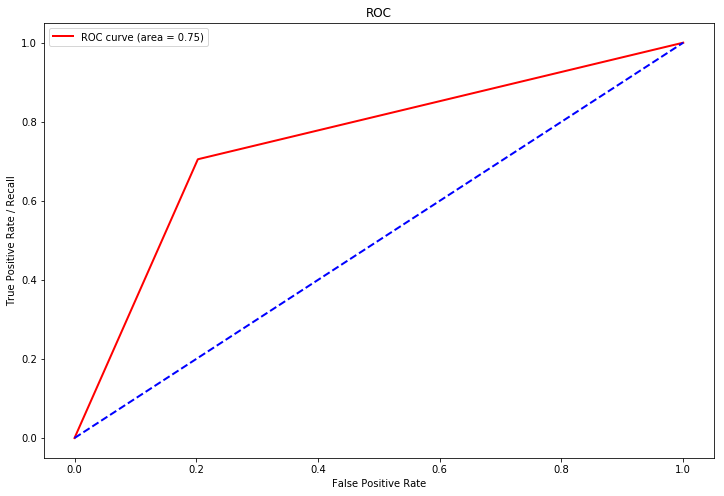

In [53]:
# plot ROC curve, percision recall curves
fpr, tpr, thresholds = roc_curve(predictions, y_test)
roc_auc = auc(fpr, tpr)

# plot ROC
plt.figure()
# draw lines
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
# plot
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Recall')
plt.legend(loc="best")
plt.show()

# plot PR curve
# precision_recall_curve

For Python: LIME, anchors, SHAP. For R: DALEX, iml
+ https://fatconference.org/static/tutorials/hall_interpretable18.pdf
+ http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html

## Reference

Open:
+ ml_walkthrough.py, ml_codebook.py
+ xgboost_chen.pdf
+ ml_advice_andrewng.pdf
+ evaluating_raschka.pdf

xgboost links:
+ API: https://xgboost.readthedocs.io/en/latest/python/python_api.html
+ parameters: https://xgboost.readthedocs.io/en/latest/parameter.html
+ tuning-kozlowski: https://www.kaggle.com/khozzy/xgboost-parameter-tuning-template/notebook
+ overfit, imbalance: https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
+ cv: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py
+ feature const: https://xgboost.readthedocs.io/en/latest/tutorials/feature_interaction_constraint.html
+ xgboost-spark: https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html
+ yarn, aws: https://xgboost.readthedocs.io/en/latest/tutorials/aws_yarn.html
+ gbm intro: https://xgboost.readthedocs.io/en/latest/tutorials/model.html
+ sci-py + dmatrix eg: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/basic_walkthrough.py
+ resources: https://github.com/dmlc/xgboost/tree/master/demo
+ examples: https://github.com/dmlc/xgboost/tree/master/demo/guide-python
+ seaborn: https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
+ bokeh: https://bokeh.pydata.org/en/latest/
+ scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
+ eval scores: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

## Notes Qs

##### Q. Explain how gradient boosting works
+ Minimize loss function (cross entropy for classification, rmse for regression) by adding weak learners
+ Weak learners added to correct residual error of previous trees
+ Optimization via gradient descent, per usual

Specifics:
+ on boosting: http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/
+ on xgboost: https://xgboost.readthedocs.io/en/latest/tutorials/model.html 
+ on adaboost: https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf

##### Q. Handle imbalanced datasets
In general: upsample minority class, downsample majority, cost-sensitive learning. For xgboost:
1. If you care only about the overall performance metric (AUC) of your prediction balance the positive and negative weights via scale_pos_weight. Use AUC for evaluation
2. If you care about predicting the right probability. In such a case, you cannot re-balance the dataset. Set parameter max_delta_step to a finite number (say 1) to help convergence. In general set scale_pos_weight = 1, min_child_weight = 1, max_delta_step = 1-10

See: https://www.jeremyjordan.me/imbalanced-data/

##### Q. Common diagnosis methods
+ Essentially checking for bias vs. variance (underfit vs. overfit). For underfit (high bias): try more complex model, more trees, more depth, adding features. For overfit (high variance - see ans below): try regularization, fewer trees, less depth, early stopping, reducing features, check for linear indep of features etc. 
+ Can also be that the underlying cost function has curvature or is non-convex (in that case try Newton, other methods). Or using the wrong type for model for the underlying data e.g. using OLS to model a non-linear relationship (try SVM vs trees vs. neural nets)
+ A common tool is to use learning curves to spot variance / bias issues in the model - see ml_advice_andrewng.pdf
+ For interpretability: LIME, anchors, SHAP (Py) and DALEX, iml (R)

See: https://www.dataquest.io/blog/learning-curves-machine-learning/

##### Q. Common evaluation methods for binary classification
1. Confusion matrix (for binary classification): a confusion matrix of binary classification is a two by two table formed by counting of the number of the four outcomes of a binary classifier (TP, FP, TN, FN):
    + Error rate = (FP + FN) / (FP + FN + TP + TN)
    + Accuracy = (TP + TN) / (FP + FN + TP + TN)
    + Sensitivity (true positive rate, recall) = TP / (TP + FN) = TP / P
    + Specificity (true negative rate) = TN / (TN + FP) = TN / N
    + Percision = TP / (TP + FP)
    + Recall = P(Y_pred | Y_true), while percision = P(Y_true | Y_pred)
    
2. ROC plot: is a model-wide evaluation measure that is based on two basic evaluation measures – specificity and sensitivity
    + Specificity is a performance measure of the whole negative part of a dataset, whereas sensitivity is a performance measure of the whole positive part
    + y = True positive rate (sensitivity)
    + x = False positive rate (1 - specificity)
    + Random classifier has a ROC curve of y = x

3. AUC score: is the area under the curve calculated under the ROC curve. Although the theoretical range of AUC score is between 0 and 1, the actual scores of meaningful classifiers are greater than 0.5, which is the AUC score of a random classifier
    + if dataset has imbalanced classes - look for early retrieval area to analyse the performance with small false positive rate
    + imbalanced classes are better analyzed via percision-recall curves

4. Precision-Recall plot: a model-wide evaluation measure that is based on two basic evaluation measures – recall and precision. 
    + Recall - is a performance measure of the whole positive part of a dataset
    + Precision - is a performance measure of positive predictions
    + y = percision
    + x = recall (aka sensitivity)
    + for imbalanced set random line (horizontal) shifts up or down

5. F1 score: is the harmonic mean of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.
    + F1 Score = 2*(Recall * Precision) / (Recall + Precision)
    + most appropriate metric for imbalanced sets

Other: Kappa, Cohen. See: http://mlwiki.org/index.php/ROC_Analysis

##### Q. Configure gradient boosting for XGBoost

A number of configuration heuristics were published in the original paper:
1. Learning rate or shrinkage (learning_rate in XGBoost) should be set to 0.1 or lower, and smaller values will require the addition of more trees
2. The depth of trees (tree_depth in XGBoost) should be configured in the range of 2-to-8, where not much benefit is seen with deeper trees
3. Row sampling (subsample in XGBoost) should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling

A good general configuration strategy is as follows:
+ Run the default configuration and review plots of the learning curves on the training and validation datasets
    + If the system is overlearning, decrease the learning rate and/or increase the number of trees
    + If the system is underlearning, speed the learning up to be more aggressive by increasing the learning rate and/or decreasing the number of trees

An efficient strategy: set the number of trees to a target value such as 100 or 1000, then tune the learning rate to find the best model. The parameters to consider tuning are:
1. The number and size of trees (n_estimators and max_depth)
2. The learning rate and number of trees (learning_rate and n_estimators)
3. The row and column subsampling rates (subsample, colsample_bytree and colsample_bylevel)

(from xgboost mini-course)

##### Q. Tune hyperparameters

The process of tuning hyperparameters with cross validation is (as always):
1. Set up a grid of hyperparameters to evaluate (Random or Grid search)
2. Randomly sample / evaluate every combination of hyperparameters
3. Create a model with the selected combination
4. Evaluate the model using K-fold cross validation
5. Pick the hyperparameters that work the best

XGBoost parameters:
0. booster: type of model to run (default: gbtree, or gblinear, dart)
1. max_depth (default = 3): increasing value makes the model more complex likely to be over-fitting. A value of 0 indicates no limit. Typical values are 2-10
2. n_estimators (default = 100): number of trees to be used (typically > 100 - although let cv fine-tune it). Is also inversely proportional to the learning_rate (eta)
3. min_child_weight (default = 1): larger the value the more convervative the algo will be (i.e. tree partitioning will stop when less than this value)
4. learning_rate (default = 0.1): is the step size shrinkage (regularlization) used to prevent overfitting, typically 0.001-0.3 small learning_rate and large n_estimators = more accurate XGBoost models
5. gamma/min_split_loss (default = 0): minimuum loss reduction reqd to make a further partition on a leaf node tree (larger value more conserv.). In other words, controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits
6. reg_alpha (default = 0): L1 regularization (larger = more conserv.), ~ lasso
7. reg_lambda (default = 1): L2 regularization (larger = more conserv.), ~ ridge
8. subsample (default = 1): setting it 0.5 means that xgboost randomly collected half of the data instances to grow trees - i.e. dictates the fraction of the training data that is used during any given boosting round. Used to prevent overfitting, low value can lead to underfitting
9. colsample_bytree (default = 1): subsample ratio of columns when constructing each tree, typically 0.5-1, high val leads to overfitting
10. scale_pos_weight (default = 1): useful for unbalanced class problems (use value > 0), typical value = sum(negative cases) / sum(positive cases)
11. also objective (binary vs. multiclass, 'binary:logistic' or 'multi:softmax'), random_state, n_jobs

CV parameters:
1. num_boost_round: ~ n_estimators
2. metrics: rmse for regression, accuracy / auc for classification
3. as_pandas: returns pandas df
4. early_stopping_rounds: finishes training of the model early if the hold-out metric does not improve for a given number of rounds
5. dtrain - dmatrix
6. nfold = number of folds for cross validations

See: https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

##### Q. Control overfitting
In general: high training accuracy, low test accuracy - likely overfit. Ways to control it in xgboost:
+ Directly control model complexity; this includes reducing max_depth or increasing min_child_weight
+ Add randomness to make training robust to noise; this includes subsample and colsample_bytree (low value)
+ Reduce stepsize eta (learning_rate) but must increase n_estimators accordingly
+ Tune for reg_alpha and reg_lambda (L1, L2 regularization terms) and gamma

##### Q. Typical machine learning workflow
(see dets/strategies in ml_codebook.py)
1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection/extraction
4. Establish a baseline and compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible

## Notes random

In [ ]:
# random tricks:
# labels = ["{0}-{1}".format(i, i + 9) for i in range(0, 100, 10)]
# df_train_set['AgeGroup'] = pd.cut(df_train_set.Age, range(0, 101, 10), right=False, labels=labels)
# labels = ["{0}-{1}".format(i, i + 4) for i in range(0, 20, 5)]
# df_train_set['Education'] = pd.cut(df_train_set.EdNum, range(0, 21, 5), right=False, labels=labels)
# np.sum(np.isnan(x_train))
# np.where(~np.isfinite(x_train))
# one hot encode: pd.get_dummies(categorical_variables)
# axis = 1 is a column bind: pd.concat([df1, df2], axis = 1)
# plt.style.use('fivethirtyeight')
# %%timeit -n 1 -r 5
# final_model.fit(X, y)

# pipelines:
# from sklearn.pipeline import Pipeline
# steps = [("xgb_model", xgb.XGBRegressor())]
# xgb_pipeline = Pipeline(steps)
# xgb_pipeline.fit(X, y)

# behavioural:
#     q. interests?
# social algo theory w + moira burke (cmu - fb), sandy p (mit medialab)
# + ariel procaccia (cmu) + ashish goel (x-twitter) + agt + usual suspects
#     q. s/w?
# + s: perseverence, curiousity, character, learner
# + w: overcommitting, self-marketing, lack of experience in online models
#     q. role of ds/ml: products, decisions, stories; entomology > structure
#     q. ml/ds experience
# + yogee (some bayes, arima, mood class: xgboost)
# + foxee (image class: log reg to xgboost to ann + recsys: ranking/scoring to
#          trees to eventually collab filtering - knn)
# + rambla (ux, product focused + cust. dev + cohorts, LTV/CAC, AB testng)
# + deloitte (conversions, wsdl, apis + bp design, managing change/client)

# dmatrix:
# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)